In [1]:
import pickle
import warnings

import pandas as pd
import plotly.express as px
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# https://www.kaggle.com/datasets/yasserh/titanic-dataset
df = pd.read_csv("../data/titanic.csv")

df_train, df_test = train_test_split(df, test_size=0.3, random_state=41)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

# Preprocessing

In [5]:
# get rid of PassengerId as it is just arbitrary
df = df.drop(columns=["PassengerId"])

## Converting categorical variables

In [6]:
# replace "male" and "female" strings to numbers
df = df.assign(Sex=lambda df_: df_["Sex"].replace({"male": 0, "female": 1}))

In [7]:
# replace name with name length
df = df.assign(NameLength=lambda df_: df_["Name"].str.len()).drop(columns=["Name"])

In [8]:
# one hot encode Embarked, why?
df = pd.get_dummies(df, columns=['Embarked'], prefix='Embarked')

In [9]:
# get rid of ticket column as it would be difficult to get meaningful information
df = df.drop(columns=["Ticket"])

In [10]:
df.head()

Survived  Pclass  Sex   Age  SibSp  Parch     Fare Cabin  NameLength  \
0         0       3    0  22.0      1      0   7.2500   NaN          23   
1         1       1    1  38.0      1      0  71.2833   C85          51   
2         1       3    1  26.0      0      0   7.9250   NaN          22   
3         1       1    1  35.0      1      0  53.1000  C123          44   
4         0       3    0  35.0      0      0   8.0500   NaN          24   

   Embarked_C  Embarked_Q  Embarked_S  
0       False       False        True  
1        True       False       False  
2       False       False        True  
3       False       False        True  
4       False       False        True

## Handle missing values

In [11]:
df.isna().sum()

Survived        0
Pclass          0
Sex             0
Age           177
SibSp           0
Parch           0
Fare            0
Cabin         687
NameLength      0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64

In [12]:
# drop Cabin column due to high number of missing values
df = df.drop(columns=["Cabin"])

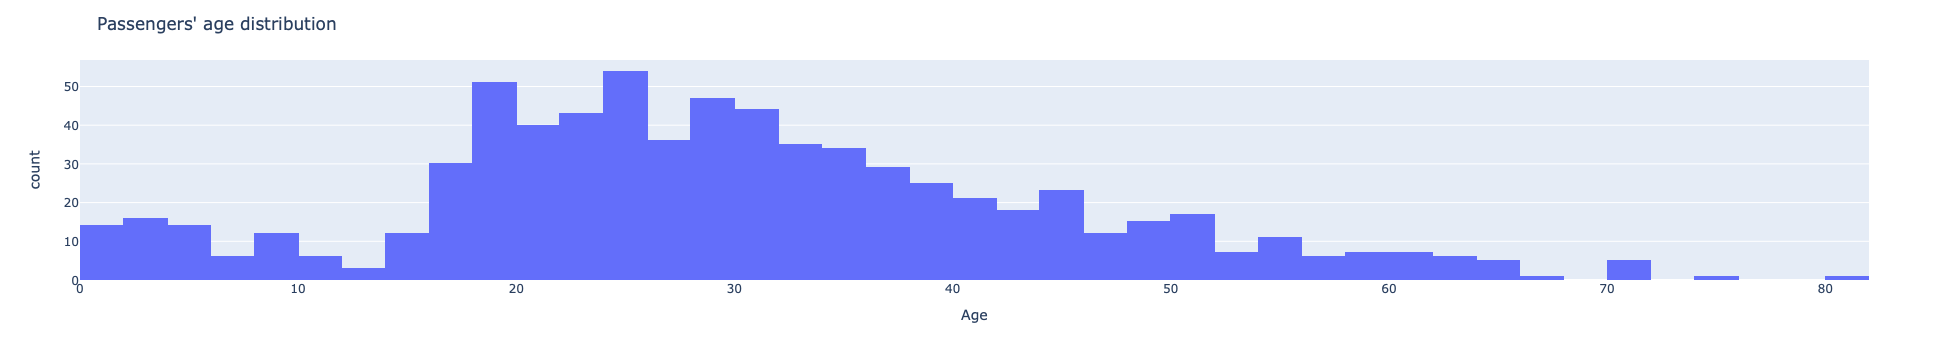

In [13]:
fig = px.histogram(df, x="Age")
fig.update_layout(title="Passengers' age distribution")
fig.show()

In [14]:
# fillna of Age and Embarked with averages, discuss other options?
df = df.fillna({"Age": df["Age"].mean()})

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   NameLength  891 non-null    int64  
 8   Embarked_C  891 non-null    bool   
 9   Embarked_Q  891 non-null    bool   
 10  Embarked_S  891 non-null    bool   
dtypes: bool(3), float64(2), int64(6)
memory usage: 58.4 KB


## We were cheating a bit

In [16]:
X_train, y_train = df_train.drop(columns=["Survived"]), df_train["Survived"]
X_test, y_test = df_test.drop(columns=["Survived"]), df_test["Survived"]

In [17]:
class TitanicDataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # Calculate mean age during fitting
        self._age_mean = X['Age'].mean()
        return self

    def transform(self, X):
        return (
            X.drop(columns=["PassengerId"])
            .assign(Sex=lambda df_: df_["Sex"].replace({"male": 0, "female": 1}))
            .assign(NameLength=lambda df_: df_["Name"].str.len())
            .drop(columns=["Name"])
            .pipe(pd.get_dummies, columns=['Embarked'], prefix='Embarked')
            .drop(columns=["Ticket"])
            .drop(columns=["Cabin"])
            .fillna({"Age": self._age_mean})
        )

In [18]:
titanic_data_preprocessor = TitanicDataPreprocessor().fit(X_train)
X_train = titanic_data_preprocessor.transform(X_train)
X_test = titanic_data_preprocessor.transform(X_test)

In [19]:
X_train.head()

Pclass  Sex        Age  SibSp  Parch     Fare  NameLength  Embarked_C  \
464       3    0  29.304165      0      0   8.0500          18       False   
451       3    0  29.304165      1      0  19.9667          31       False   
62        1    0  45.000000      1      0  83.4750          27       False   
705       2    0  39.000000      0      0  26.0000          46       False   
712       1    0  48.000000      1      0  52.0000          24       False   

     Embarked_Q  Embarked_S  
464       False        True  
451       False        True  
62        False        True  
705       False        True  
712       False        True

# Feature selection

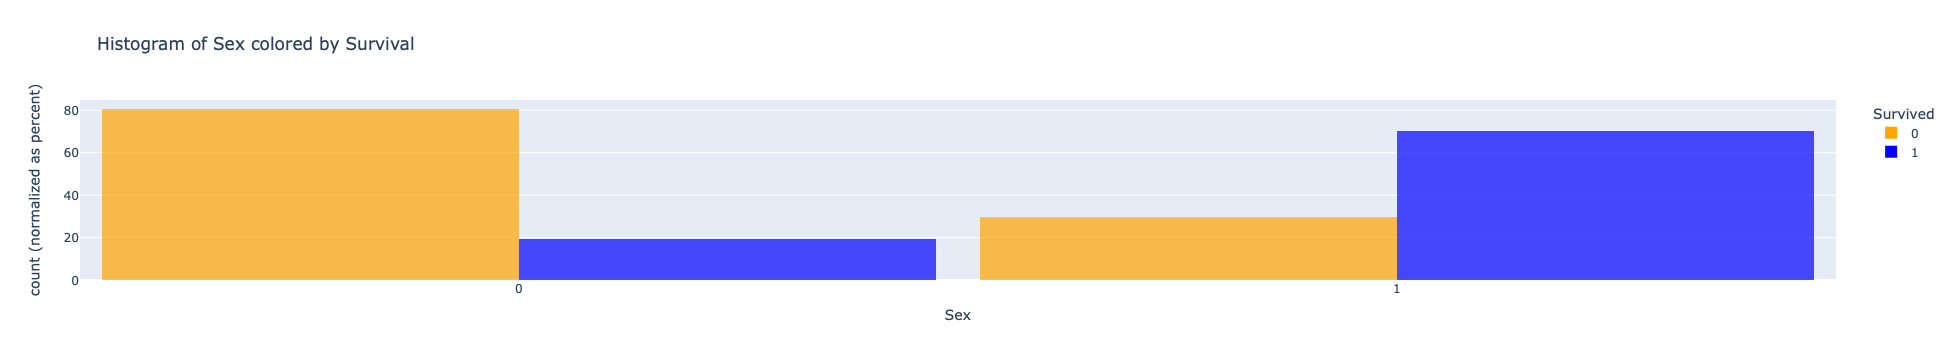

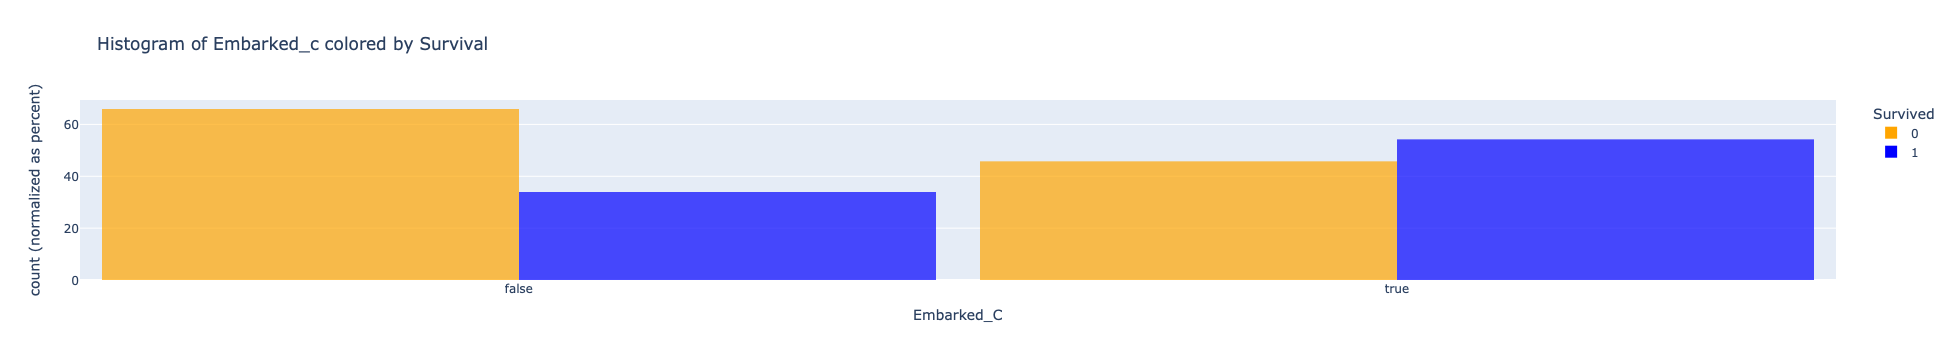

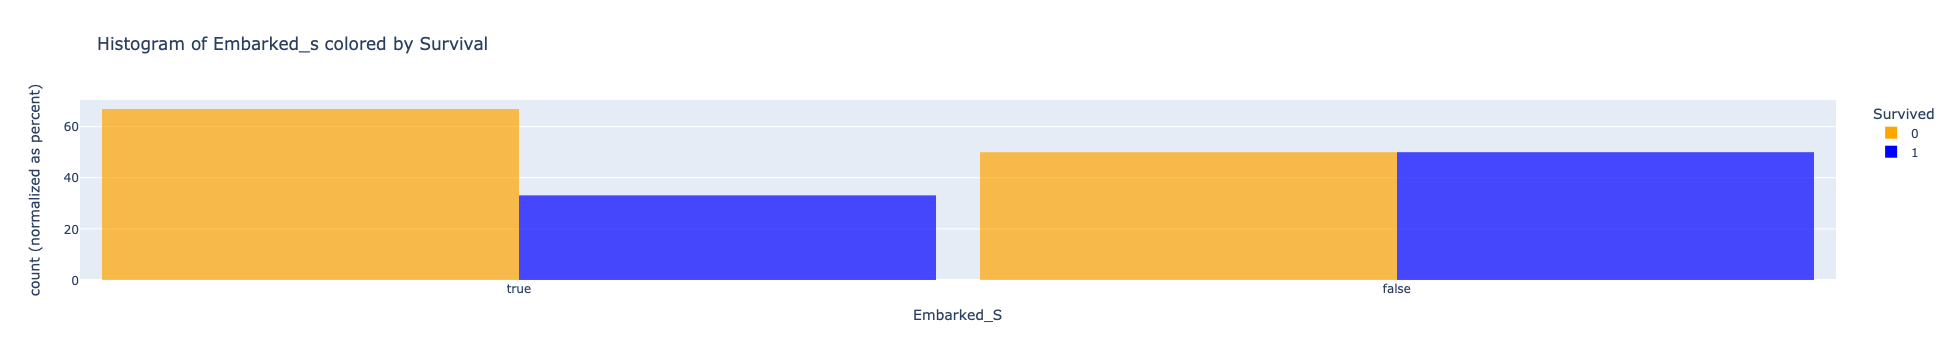

In [20]:
df_train_prep = titanic_data_preprocessor.transform(df_train)

for feature in df_train_prep.drop(columns=["Survived"]).columns:
    fig = px.histogram(
        df_train_prep,
        x=feature,
        color="Survived",
        color_discrete_map={0: 'orange', 1: 'blue'},
        barnorm='percent',
        barmode='group',
        opacity=0.7,
        title=f'Histogram of {feature.capitalize()} colored by Survival',
    )
    fig.update_layout(bargap=0.05)
    fig.show()

In [21]:
correlations = X_train.corrwith(y_train)
correlations

Pclass       -0.355413
Sex           0.505074
Age          -0.084131
SibSp        -0.063485
Parch         0.028687
Fare          0.271450
NameLength    0.270722
Embarked_C    0.162986
Embarked_Q    0.016156
Embarked_S   -0.156761
dtype: float64

In [22]:
class TitanicDataFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        correlations = X.corrwith(y)
        self._selected_feature_columns = list(correlations.abs().nlargest(4).index)
        return self

    def transform(self, X):
        return X[self._selected_feature_columns]

In [23]:
titanic_data_feature_selector = TitanicDataFeatureSelector().fit(X_train, y_train)

In [24]:
X_train = titanic_data_feature_selector.transform(X_train)
X_test = titanic_data_feature_selector.transform(X_test)

In [25]:
X_train.head()

Sex  Pclass     Fare  NameLength
464    0       3   8.0500          18
451    0       3  19.9667          31
62     0       1  83.4750          27
705    0       2  26.0000          46
712    0       1  52.0000          24

# Modeling

In [26]:
clf = DecisionTreeClassifier().fit(X_train, y_train)

In [27]:
accuracy_score(clf.predict(X_test), y_test)

0.7723880597014925

In [35]:
from sklearn import tree
from matplotlib import pyplot as plt

plt.figure(figsize=(60, 60))
           
tree.plot_tree(clf)
plt.savefig("../models/tree.png")

In [29]:
df = pd.read_csv("../data/titanic.csv")

df_train, df_test = train_test_split(df, test_size=0.3, random_state=41)
X_train, y_train = df_train.drop(columns=["Survived"]), df_train["Survived"]
X_test, y_test = df_test.drop(columns=["Survived"]), df_test["Survived"]

pipeline = Pipeline(
    [
        ('preprocessor', TitanicDataPreprocessor()),
        ('feature_selector', TitanicDataFeatureSelector()),
        ('classifier', DecisionTreeClassifier()),
    ]
)

titanic_classification_pipeline = pipeline.fit(X_train, y_train)

In [30]:
def save_model(model, path: str):
    """Saves model as pickle file"""
    with open(path, 'wb') as file:
        pickle.dump(model, file)

In [31]:
save_model(titanic_classification_pipeline, "../models/titanic_classification_pipeline.pkl")